In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scripts.analysis import data, plot



plot.init_matplotlib()

W, H = 5.5, 2.5
WINDOW_SIZE = 4
THRESHOLD = 50


def plot_window(data, ax):
    columns, colors, kinds, params = (
        [
            "n_stars",
            "n_stars_fake",
            "past_median",
            "threshold",
        ],
        ["C0", "C2", "C1", "C3"],
        ["bar", "bar", "line", "line"],
        [{}, {}, {}, {"style": "--"}],
    )
    for column, color, kind, params in zip(columns, colors, kinds, params):
        data.plot(
            kind=kind,
            x="month",
            y=column,
            ax=ax,
            color=color,
            **params,
        )
    ax.fill_between(
        data.month,
        data.past_median - data.past_mad,
        data.past_median + data.past_mad,
        color="C1",
        alpha=0.2,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(
        handles=[handles[2], handles[3], handles[0], handles[1]],
        labels=[
            "# Stars (per Month)",
            "# Suspected Fake Stars (per Month)",
            "Past Median (±MAD)",
            "Anomaly Threshold",
        ],
    )
    return ax

In [2]:
repos, months = data.get_fake_star_repos(), data.get_fake_stars_by_month()

In [3]:
months["past_median"], months["past_mad"] = 0.0, 0.0
for repo, df in tqdm(months.groupby("repo")):
    for i, month in enumerate(df["month"]):
        past_values = [df["n_stars"].iloc[j] for j in range(i)][-WINDOW_SIZE:]
        if len(past_values) > 0:
            past_median = np.median(past_values)
            past_mad = np.median([abs(x - past_median) for x in past_values])
        else:
            past_median, past_mad = 0, 0
        months.loc[df.index[i], "past_median"] = past_median
        months.loc[df.index[i], "past_mad"] = past_mad
months["threshold"] = (
    months.past_median + months.past_mad + np.maximum(months.past_mad, THRESHOLD)
)
months["anomaly"] = (
    (months.n_stars >= months.threshold)
    & (months.n_stars_fake >= 50)
    & (months.n_stars_fake >= 0.5 * months.n_stars)
)

100%|██████████| 22915/22915 [01:57<00:00, 194.36it/s]


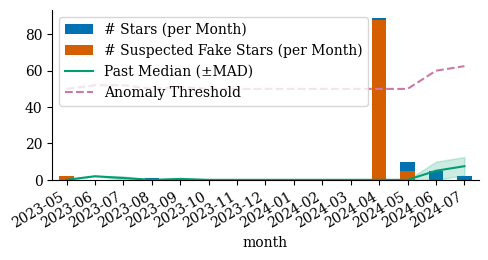

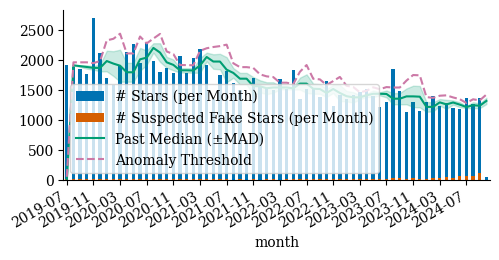

In [4]:
# two typical examples gqylpy/funccache and microsoft/vscode
months_gqylpy = months[months["repo"] == "gqylpy/funccache"]
months_vscode = months[months["repo"] == "microsoft/vscode"]

fig, ax = plt.subplots(figsize=(W, H))
plot_window(months_gqylpy, ax=ax)
fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(W, H))
plot_window(months_vscode, ax=ax)
ax.set_xticks(range(0, len(months_vscode), 4))
ax.set_xticklabels(months_vscode["month"].iloc[::4])
fig.autofmt_xdate()

100it [00:10,  9.16it/s]


15720 6499 972


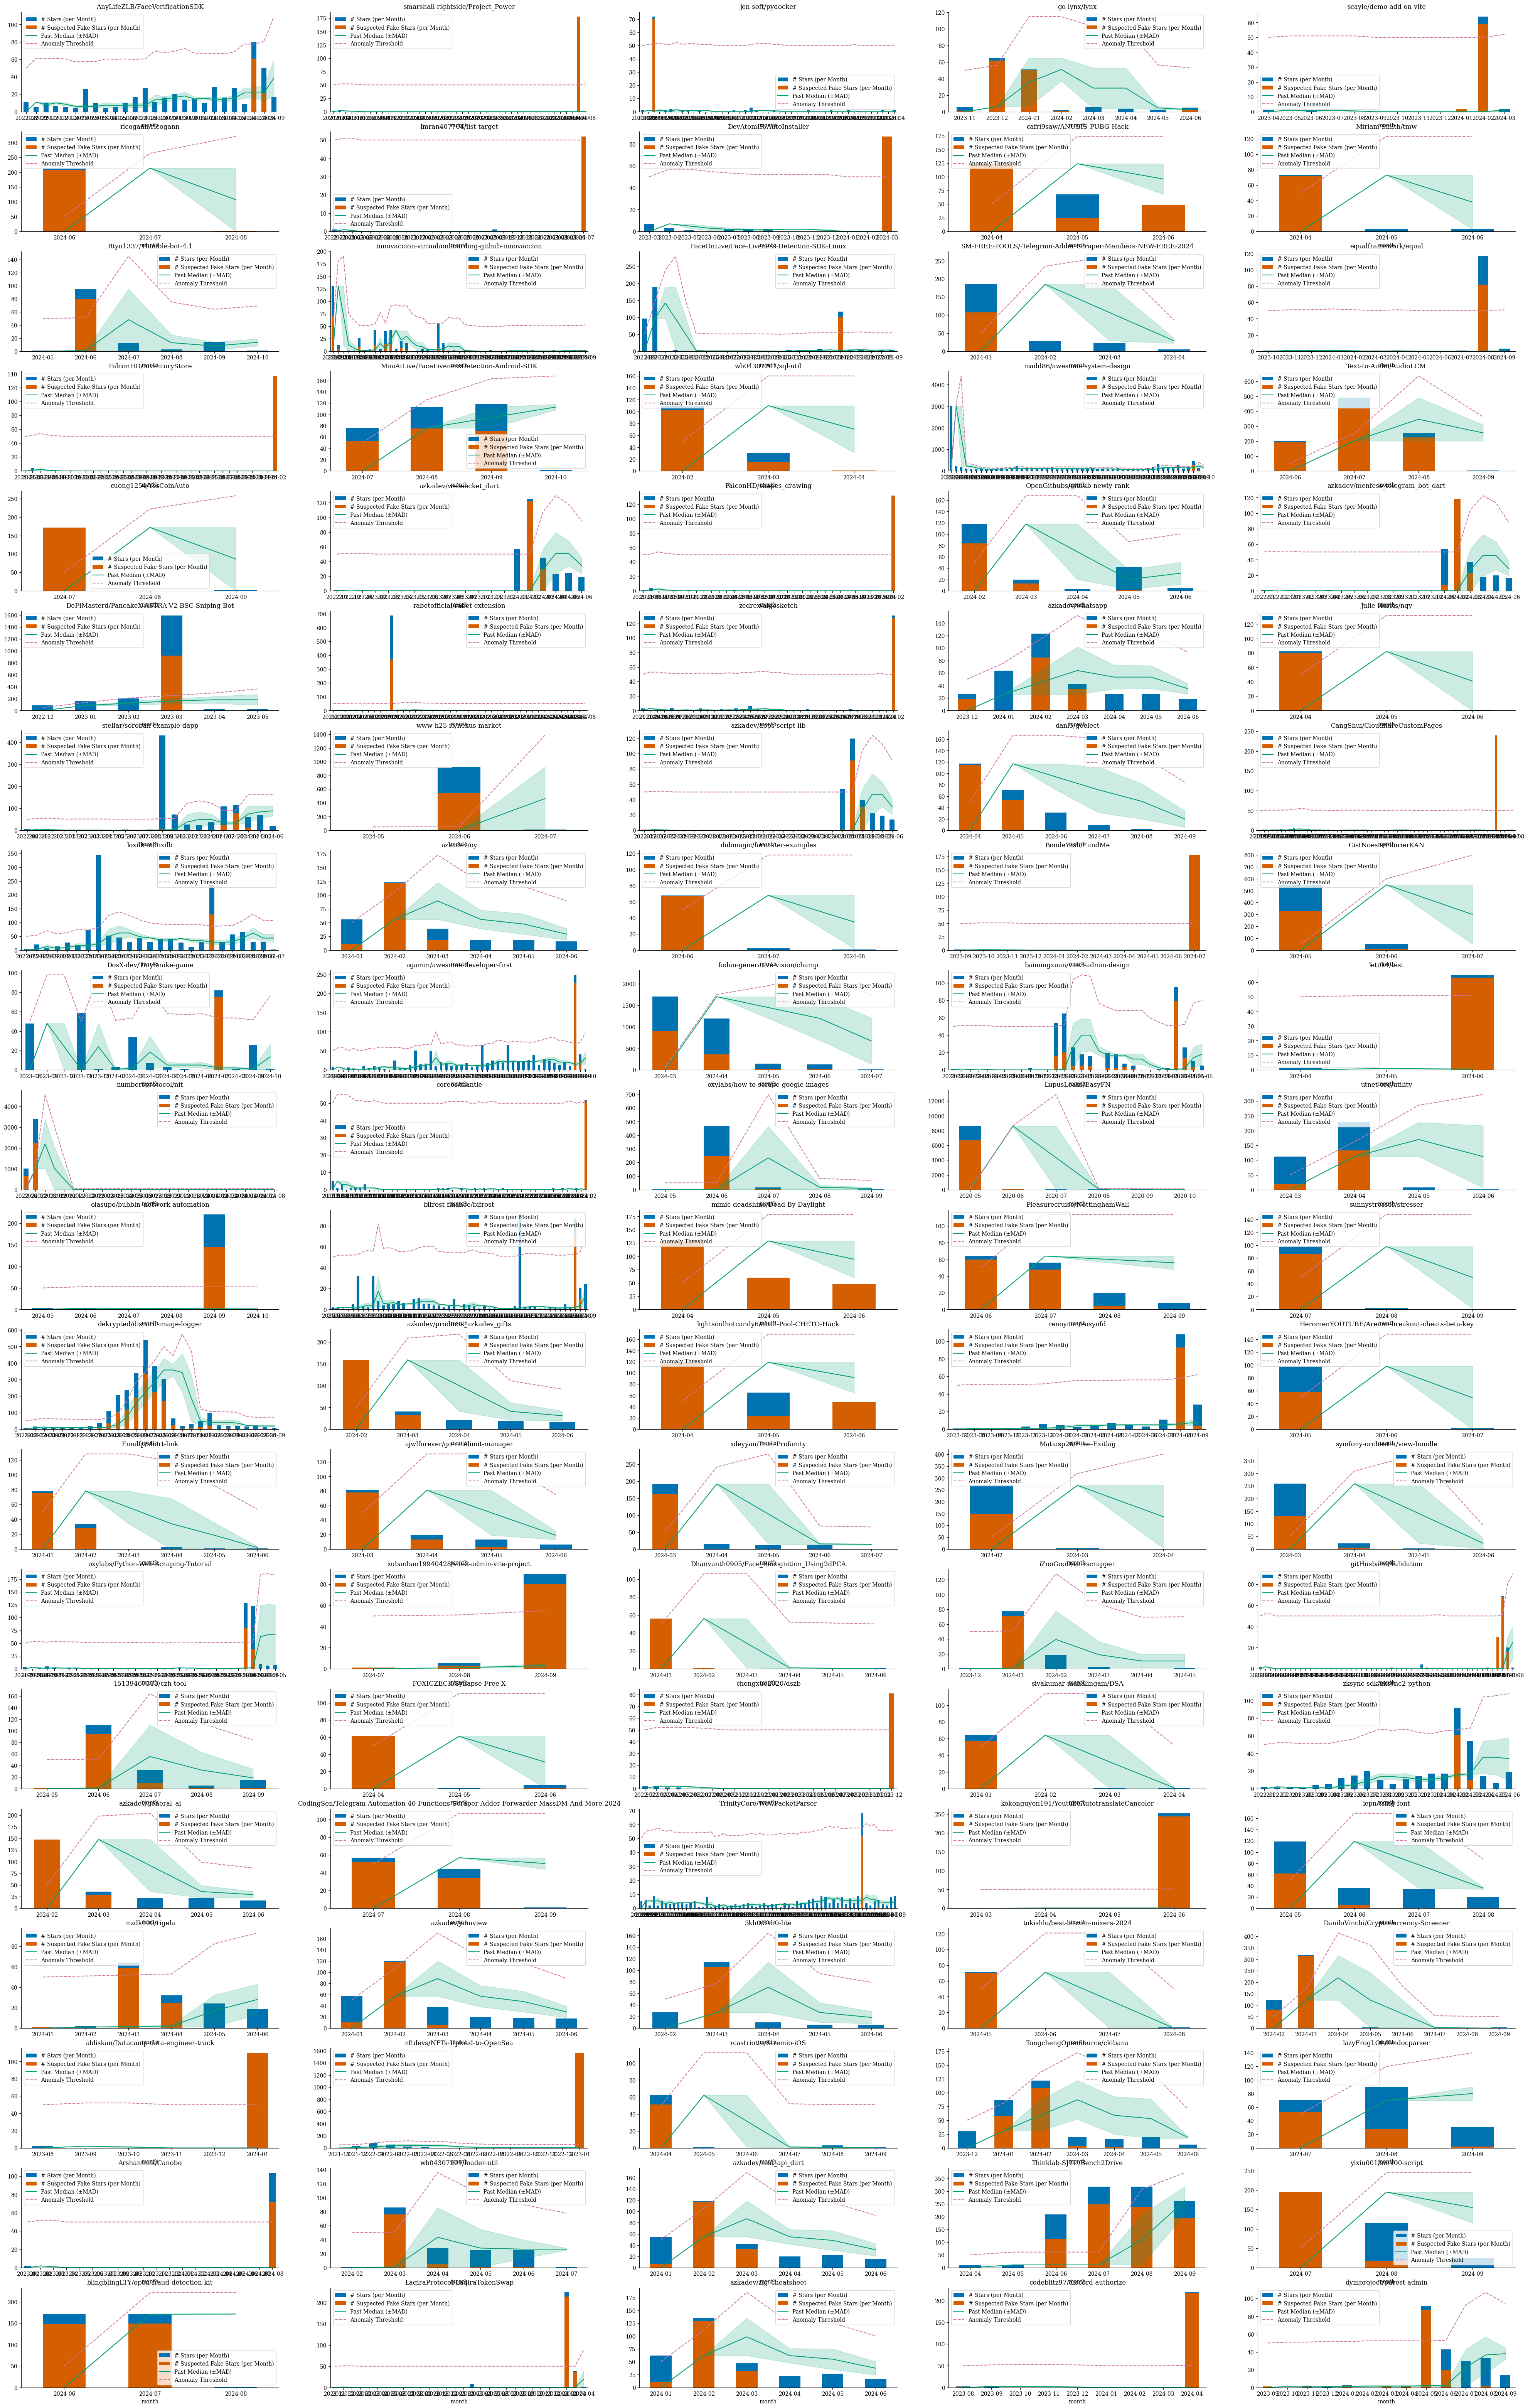

In [5]:
# randomly sample 100 repos and plot them
anomaly_repos = set(months[months.anomaly].repo.unique())
long_lived_repos = set(
    months.groupby("repo").filter(lambda x: len(x) >= 3).repo.unique()
)
sample = random.sample(list(anomaly_repos & long_lived_repos), 100)

fig, axes = plt.subplots(20, 5, figsize=(50, 80))
for i, repo in tqdm(enumerate(sample)):
    df = months[months["repo"] == repo]
    ax = axes[i // 5, i % 5]
    plot_window(df, ax=ax)
    ax.set_title(repo)

print(len(anomaly_repos), len(long_lived_repos), len(anomaly_repos & long_lived_repos))